<h1>Siamese Network with Manhattan LSTM<h1>
<h5>Here we use Siamese network as a fewshot mehanism to classify tweets<h5>

In [4]:
#importing libraries
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Subtract, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential, Model
import itertools
from keras.optimizers import Adam
from keras.optimizers import SGD
import dill
import gensim
import matplotlib.pyplot as plt
from sklearn import metrics

<h5>All experiements in this notebook is performed with cleaned tweets as input data<h5>

In [6]:
#import the cleaned dataset
train_df = pd.read_pickle('./train_df_cleaned.pkl')
test_df = pd.read_pickle('./test_df_cleaned.pkl')

<h5>Checking for equal class distribution<h5>

In [9]:
test_df['related_manual'].value_counts()

related_manual
1.0    250
0.0    250
Name: count, dtype: int64

In [10]:
train_df['related_manual'].value_counts()

related_manual
1.0    1000
0.0    1000
Name: count, dtype: int64

In [12]:
#The below code is used to create a few shot corpus by selecting 50 examples each from both class. Once generated its saved as a pickle file
'''positive_examples = train_df[train_df['related_manual']==1].head(50)
negative_examples = train_df[train_df['related_manual']==0].head(50)
fewshot_df = pd.concat([positive_examples,negative_examples])
fewshot_df.to_pickle('./fewshot_df_100.pkl')'''

"positive_examples = train_df[train_df['related_manual']==1].head(50)\nnegative_examples = train_df[train_df['related_manual']==0].head(50)\nfewshot_df = pd.concat([positive_examples,negative_examples])\nfewshot_df.to_pickle('./fewshot_df_100.pkl')"

In [13]:
fewshot_df = pd.read_pickle('./fewshot_df_100_cleaned.pkl')

In [14]:
#helper function to generate pairwise dataset
def get_pairwise_dataset(df,train_column_name,target_column_name):
    
    frame_train = {'Tweet': df[train_column_name],
         'Class': df[target_column_name]}
    df_train = pd.DataFrame(frame_train)
    
    labels = df_train['Class'].unique()
    
    #initialise empty arrays for storing left and right tweets
    lhs = []
    rhs = []
    is_similar = []
    
    for label in labels:
        print(label)
        similar_tweets = list(df_train[df_train['Class']==label]['Tweet'])
        similar_tweet_pairs = []
        #find combinations of 2 from similar tweets
        for i in range(len(similar_tweets)):
            for j in range(i+1,len(similar_tweets)):
                similar_tweet_pairs.append((similar_tweets[i], similar_tweets[j]))
                
        
        print(len(similar_tweet_pairs))
        for pair in similar_tweet_pairs:
            lhs.append(pair[0])
            rhs.append(pair[1])
            
            #is_similar 1 since tweets belong to same class
            is_similar.append(1.0)
        
        #make random combinations for different tweets
        diffierent_tweets = df_train[df_train['Class']!=label]['Tweet']
        for i in range(len(similar_tweet_pairs)):
            lhs.append(np.random.choice(similar_tweets))
            rhs.append(np.random.choice(diffierent_tweets))
            
            #is_smilar 0 becuase tweets belong to different class
            is_similar.append(0.0)
            
    dataset = pd.DataFrame({'left_tweet':lhs,
    'right_tweet':rhs,
    'is_similar': is_similar})
    
    return dataset

In [15]:
#setting a fixed upper limit for the unique number of words
len_vocab = 10000

In [16]:
#helper function to tokenize the tweets
def get_tokenized_data(dataset, data_column_name, target_column_name):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(train_df[data_column_name])
    left_tweet_tokenized = tokenizer.texts_to_sequences(dataset.left_tweet)
    right_tweet_tokenized = tokenizer.texts_to_sequences(dataset.right_tweet)
    tweet_tokenized = tokenizer.texts_to_sequences(train_df[data_column_name])
    text_complete = tokenizer.sequences_to_texts(tweet_tokenized)
    text_complete = [item.split() for item in text_complete]
    
    #word index is the lookup dictionary with unique words and their corresponding token ids
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #padding sequences for uniform representation for learning
    left_tweet_padded = pad_sequences(left_tweet_tokenized, 300)
    right_tweet_padded = pad_sequences(right_tweet_tokenized, 300)

    print(left_tweet_padded.shape)
    print(right_tweet_padded.shape)
    return left_tweet_padded,right_tweet_padded,text_complete, word_index, tokenizer

In [17]:
#generate pairwise dataset from the 100 examples
dataset_pairwise = get_pairwise_dataset(fewshot_df, 'tweet_preprocessed','related_manual')
dataset_pairwise

1.0
1225
0.0
1225


,left_tweet,right_tweet,is_similar
0,nonelectricfuel mowers2 dont mow let wild lown...,youll need explain carbon sink comment commerc...,1.0
1,nonelectricfuel mowers2 dont mow let wild lown...,excellent clip simon yes difficult value maybe...,1.0
2,nonelectricfuel mowers2 dont mow let wild lown...,looking different habitats provide stack biodi...,1.0
3,nonelectricfuel mowers2 dont mow let wild lown...,carbon sequestration calcs opportunities orgs ...,1.0
4,nonelectricfuel mowers2 dont mow let wild lown...,ps develop carbon capture planting trees,1.0
...,...,...,...
4895,amp built fossil fuelseg steel concrete fertil...,making space water northwoods rewilding networ...,0.0
4896,steel industry dont want coke sop levelling kn...,listen ygs landscapes talk carbon sequestratio...,0.0
4897,meant gross emissions co2 capita total,method sustainably times better natural seques...,0.0
4898,kielder kracker today great gravel route didnt...,listen ygs landscapes talk carbon sequestratio...,0.0


In [18]:
tweet_left, tweet_right, tokenized_tweets, word_index, tokenizer = get_tokenized_data(dataset_pairwise,'tweet_preprocessed','related_manual')

Found 7582 unique tokens.
(4900, 300)
(4900, 300)


In [23]:
%%time
#generate word2vec embeddings
word2vector_model = gensim.models.Word2Vec(
            tokenized_tweets,
            size=300,
            window=5,
            min_count=2,                                  
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 10
) 

word2vector_model.train(tokenized_tweets, total_examples= len(tokenized_tweets), epochs=20)

CPU times: user 5.47 s, sys: 56.3 ms, total: 5.52 s
Wall time: 2.48 s


(396132, 539780)

In [24]:
num_words = min(len_vocab, len(word_index)) + 1

In [25]:
#helper function to generate embedding matrix for word2vec embeddings of each unique word in the word index
def get_word2vec_embedding(word_index):
    embedding_matrix = np.zeros((num_words, 300))
    for word, i in word_index.items():
        if i > len_vocab:
            continue
        try:
            embedding_vector = word2vector_model[word].reshape((1, 300))
        except KeyError:
            continue
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [26]:
#generate the word2vec embedding matrix
word2vec_embedding_matrix = get_word2vec_embedding(word_index)
word2vec_embedding_matrix

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1094/3547789326.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = word2vector_model[word].reshape((1, 300))


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08744598,  0.1818251 , -0.03488915, ...,  0.27121946,
        -0.13898911, -0.02019383],
       [-0.16497707, -0.10579548, -0.13405667, ...,  0.03391583,
        -0.07003078, -0.15413359],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
#define manhattan distance function
def manhattan(difference):
    return K.exp(-K.sum(K.abs(difference), axis=1, keepdims=True))

In [28]:
#helper to initalise the siamese network
def initialise_siamese_network(size, embedding_matrix, optimiser='adam', lr=0.01):
    
    if optimiser == 'adam':
        optimizer = Adam
    elif optimiser == 'sgd':
        optimizer = SGD

    
    left_input_layer = Input((size,))
    right_input_layer = Input((size,))

    
    embedding_layer = Embedding(num_words,
                                300,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=size,
                                trainable=False)

    sequential_layer = Sequential()
    sequential_layer.add(embedding_layer)
    sequential_layer.add(LSTM(50, dropout=0.3, recurrent_dropout=0.))

    left_output_layer = sequential_layer(left_input_layer)
    right_output_layer = sequential_layer(right_input_layer)

    
    difference_layer = Subtract()([left_output_layer, right_output_layer])
    malstm_difference = Lambda(manhattan)(difference_layer)

    siamese_network = Model(inputs=[left_input_layer, right_input_layer], outputs=malstm_difference)
    siamese_network.compile(loss="binary_crossentropy", optimizer=optimizer(learning_rate=lr), metrics=['accuracy'])

    return siamese_network

In [29]:
#helper for prediction
def predict(tweet, train_data, compare_sequence, model):
    #convert tweet into tokenized sequence
    sequence = tokenizer.texts_to_sequences(tweet.split())
    
    #convert the sequence into a flat 1-d array
    sequence = list(itertools.chain.from_iterable(sequence))
    
    #pad the sequence for uniform represntation 
    sequence = pad_sequences([sequence], maxlen=300)
    
    #replicate the sequence to match the number of comparision sequence, to calculate similarity of each comparison sequnce to the text sequence
    sequence_array = np.repeat(sequence, len(compare_sequence), axis=0)
    
    #predict similarity score
    scores = model.predict([sequence_array, compare_sequence])
    
    #find the most similar tweet's index
    top_index = np.argmax(scores)
    
    #return prediction
    prediction = train_data['related_manual'].iloc[top_index]
    return prediction

In [30]:
#helper for generating performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
#helper to plot model accuracy curve
def plot_accuracy_curve (model):
    plt.plot(model.history['loss'])
    #plt.plot(model.history['val_accuracy'])
    plt.title('loss curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [32]:
#the compare tweet sequence hold the data from the fewshot corpus in the tokenized form.
#It is used to compare the similarity of a given tweet to each tweet in the few shot dataset.
compare_tweet_sequences = tokenizer.texts_to_sequences(fewshot_df.tweet_preprocessed)
compare_tweet_sequences_padded = pad_sequences(compare_tweet_sequences, maxlen=300)

<h2>Training and testing with different hyperparam combo<h2>

<h5>Now we run the model with different combination of hyperparameters and find the best performing model<h5>

In [33]:
siamese_1 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_1.summary()

2023-08-15 11:25:51.494667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-15 11:25:51.494716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-15 11:25:53.021853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 11:25:53.022771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 50)           2345100     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 50)           0           ['sequential[0][0]',         

2023-08-15 11:25:53.364839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 11:25:53.366205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 11:25:53.367123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [34]:
%%time
model1 = siamese_1.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-15 11:25:58.124946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 11:25:58.126298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 11:25:58.127848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 26s 137ms/step - loss: 0.4610 - accuracy: 0.7904
Epoch 2/5
154/154 [==============================] - 21s 138ms/step - loss: 0.4412 - accuracy: 0.8196
Epoch 3/5
154/154 [==============================] - 21s 135ms/step - loss: 0.1846 - accuracy: 0.9663
Epoch 4/5
154/154 [==============================] - 21s 134ms/step - loss: 0.1146 - accuracy: 0.9867
Epoch 5/5
154/154 [==============================] - 21s 136ms/step - loss: 0.0683 - accuracy: 0.9984
CPU times: user 1min 25s, sys: 20.1 s, total: 1min 45s
Wall time: 1min 50s


In [35]:
%%time
y_pred1 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_1) for tweet in test_df['tweet_preprocessed']]

2023-08-15 12:25:57.381472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 12:25:57.382552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 12:25:57.383821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 2s

2023-08-15 12:25:57.695996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 12:25:57.703195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step
CPU times: user 1min 36s, sys: 16.2 s, total: 1min 52s
Wall time: 1min 59s


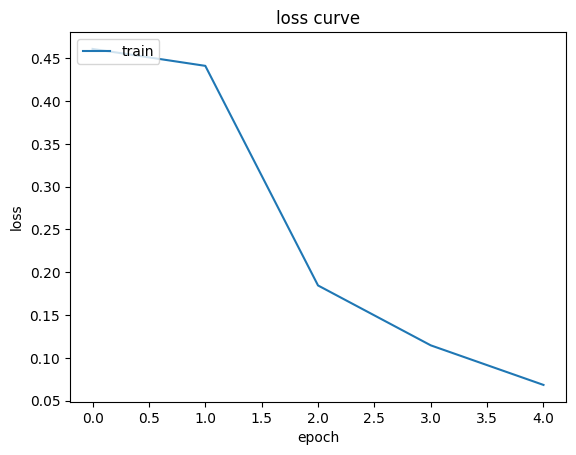

Accuracy: 87.6%
[205  45  17 233]
TP: 205
FP: 17
TN: 233
FN: 45
Sensitivity: 82.0%
Specificity: 93.2%
Precision: 92.342%
Recall: 82.0%
f1: 86.864%


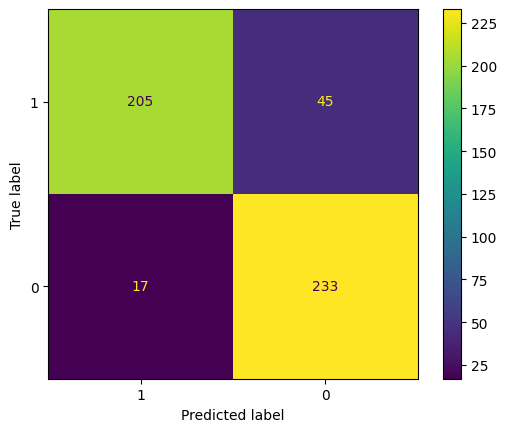

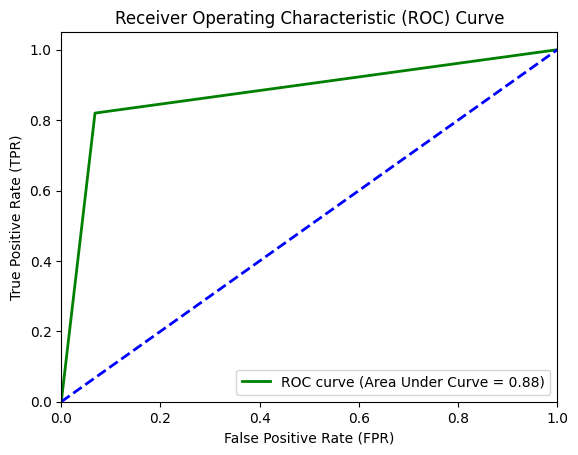

In [36]:
plot_accuracy_curve(model1)
performance(test_df['related_manual'],y_pred1)

In [61]:
siamese_2 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.1)
siamese_2.summary()

2023-08-15 15:45:04.242368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:45:04.244064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:45:04.245292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 50)           2345100     ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 subtract_7 (Subtract)          (None, 50)           0           ['sequential_7[0][0]',     

2023-08-15 15:45:04.682891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:45:04.683929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:45:04.685080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [62]:
%%time
model2 = siamese_2.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-15 15:45:05.005189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:45:05.006268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:45:05.007495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 144ms/step - loss: 0.8345 - accuracy: 0.5514
Epoch 2/5
154/154 [==============================] - 21s 139ms/step - loss: 0.8130 - accuracy: 0.5837
Epoch 3/5
154/154 [==============================] - 22s 140ms/step - loss: 0.7563 - accuracy: 0.5988
Epoch 4/5
154/154 [==============================] - 22s 141ms/step - loss: 0.7141 - accuracy: 0.6298
Epoch 5/5
154/154 [==============================] - 22s 140ms/step - loss: 0.6910 - accuracy: 0.6410
CPU times: user 1min 25s, sys: 20.1 s, total: 1min 45s
Wall time: 1min 51s


In [63]:
%%time
y_pred2 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_2) for tweet in test_df['tweet_preprocessed']]

2023-08-15 15:46:56.693654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:46:56.694595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:46:56.695742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 46ms/step
CPU times: user 1min 39s, sys: 17.5 s, total: 1min 57s
Wall time: 2min 2s


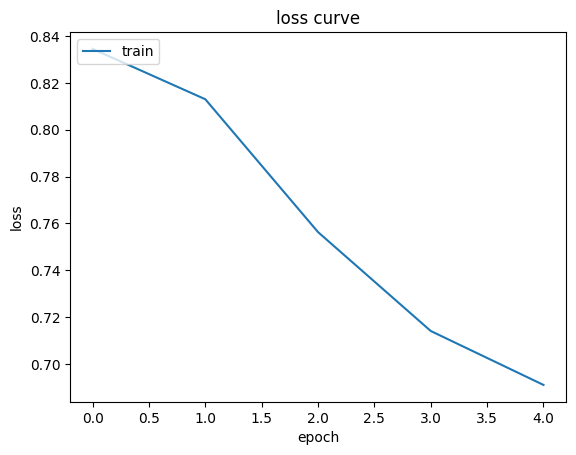

Accuracy: 60.6%
[154  96 101 149]
TP: 154
FP: 101
TN: 149
FN: 96
Sensitivity: 61.6%
Specificity: 59.6%
Precision: 60.392%
Recall: 61.6%
f1: 60.99%


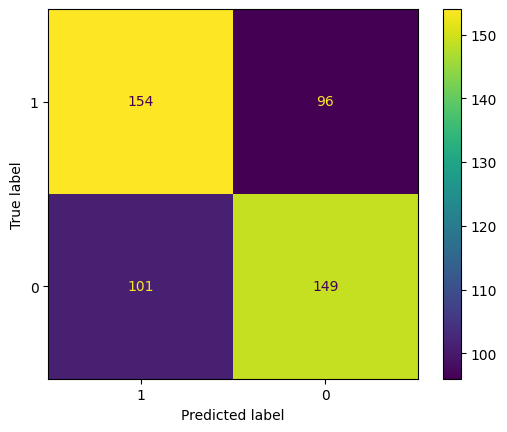

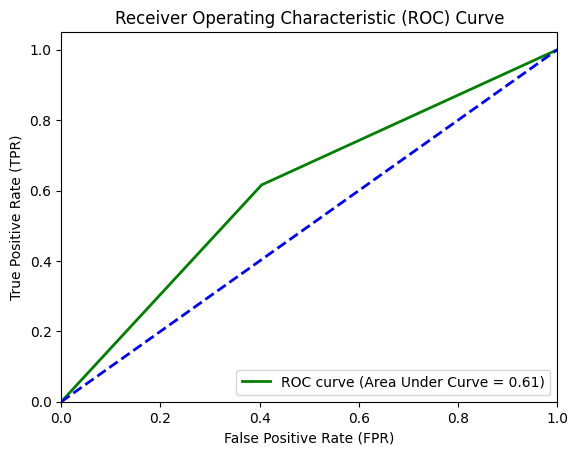

In [64]:
plot_accuracy_curve(model2)
performance(test_df['related_manual'],y_pred2)

In [41]:
siamese_3 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.001)
siamese_3.summary()

2023-08-15 12:47:47.342033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 12:47:47.343742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 12:47:47.344983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 50)           2345100     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 subtract_2 (Subtract)          (None, 50)           0           ['sequential_2[0][0]',     

2023-08-15 12:47:47.709501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 12:47:47.710555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 12:47:47.711651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [42]:
%%time
model3 = siamese_3.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-15 12:47:48.026680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 12:47:48.028118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 12:47:48.029217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 142ms/step - loss: 0.6811 - accuracy: 0.6092
Epoch 2/5
154/154 [==============================] - 21s 136ms/step - loss: 0.4679 - accuracy: 0.8131
Epoch 3/5
154/154 [==============================] - 21s 136ms/step - loss: 0.3326 - accuracy: 0.9157
Epoch 4/5
154/154 [==============================] - 21s 137ms/step - loss: 0.2640 - accuracy: 0.9590
Epoch 5/5
154/154 [==============================] - 21s 137ms/step - loss: 0.2309 - accuracy: 0.9653
CPU times: user 1min 26s, sys: 19.8 s, total: 1min 46s
Wall time: 1min 49s


In [43]:
%%time
y_pred3 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_3) for tweet in test_df['tweet_preprocessed']]

2023-08-15 12:49:37.574729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 12:49:37.575848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 12:49:37.577218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 2s

2023-08-15 12:49:37.873929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 12:49:37.877953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 54ms/step
CPU times: user 1min 40s, sys: 16.8 s, total: 1min 57s
Wall time: 1min 58s


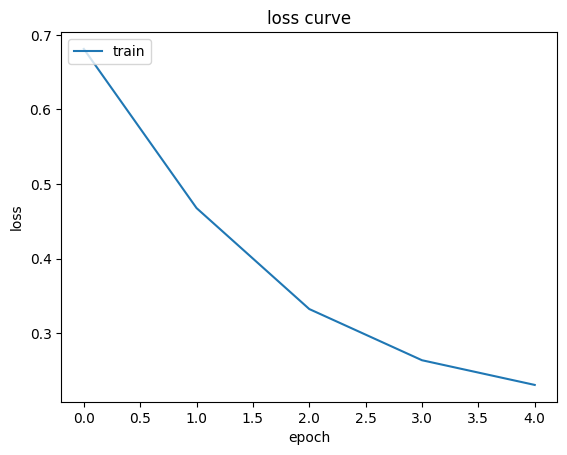

Accuracy: 88.6%
[206  44  13 237]
TP: 206
FP: 13
TN: 237
FN: 44
Sensitivity: 82.4%
Specificity: 94.8%
Precision: 94.064%
Recall: 82.4%
f1: 87.847%


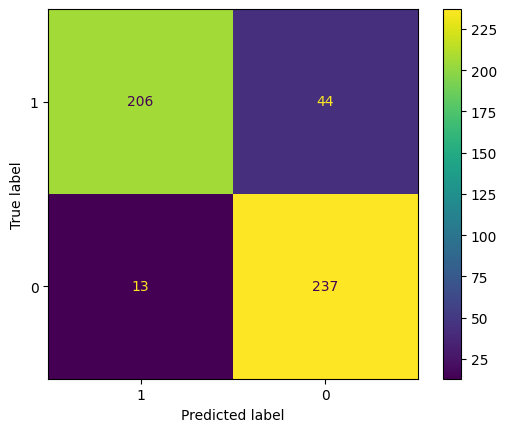

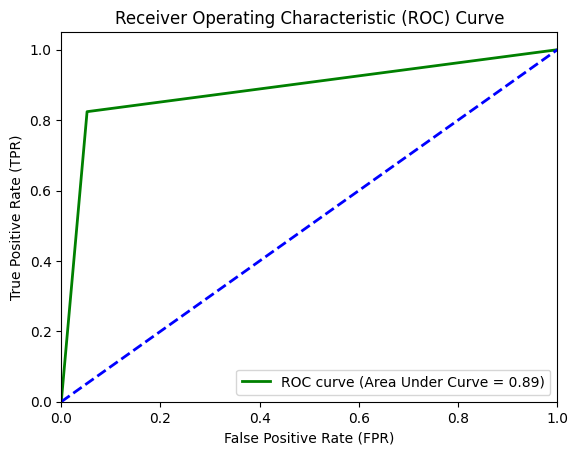

In [44]:
plot_accuracy_curve(model3)
performance(test_df['related_manual'],y_pred3)

In [45]:
siamese_4 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.001)
siamese_4.summary()

2023-08-15 14:43:22.333769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:43:22.334789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:43:22.336003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 50)           2345100     ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 subtract_3 (Subtract)          (None, 50)           0           ['sequential_3[0][0]',     

2023-08-15 14:43:22.668870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:43:22.670254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:43:22.671138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
%%time
model4 = siamese_4.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=10)

Epoch 1/10


2023-08-15 14:43:22.985474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:43:22.986553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:43:22.987843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 24s 136ms/step - loss: 0.6809 - accuracy: 0.6124
Epoch 2/10
154/154 [==============================] - 21s 136ms/step - loss: 0.4660 - accuracy: 0.8206
Epoch 3/10
154/154 [==============================] - 21s 135ms/step - loss: 0.3366 - accuracy: 0.9110
Epoch 4/10
154/154 [==============================] - 21s 135ms/step - loss: 0.2667 - accuracy: 0.9488
Epoch 5/10
154/154 [==============================] - 21s 135ms/step - loss: 0.2202 - accuracy: 0.9663
Epoch 6/10
154/154 [==============================] - 21s 136ms/step - loss: 0.1936 - accuracy: 0.9704
Epoch 7/10
154/154 [==============================] - 21s 137ms/step - loss: 0.1677 - accuracy: 0.9829
Epoch 8/10
154/154 [==============================] - 21s 137ms/step - loss: 0.1499 - accuracy: 0.9857
Epoch 9/10
154/154 [==============================] - 21s 137ms/step - loss: 0.1377 - accuracy: 0.9857
Epoch 10/10
154/154 [==============================] - 19s 123ms/step - loss: 0.1241

In [47]:
%%time
y_pred4 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_4) for tweet in test_df['tweet_preprocessed']]

2023-08-15 14:46:52.843302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:46:52.844685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:46:52.845759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 1s

2023-08-15 14:46:53.147068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 14:46:53.152280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 44ms/step
CPU times: user 1min 34s, sys: 15.8 s, total: 1min 49s
Wall time: 1min 58s


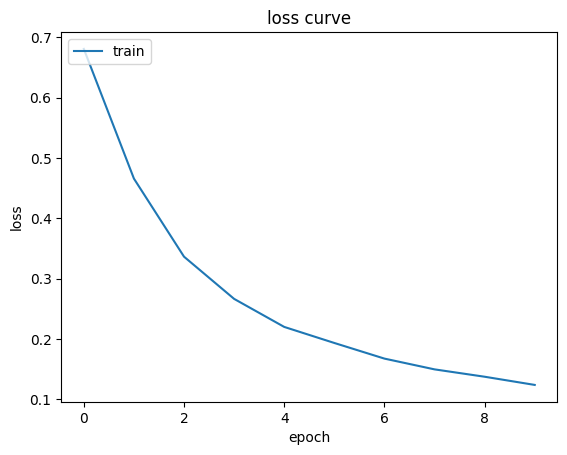

Accuracy: 89.4%
[212  38  15 235]
TP: 212
FP: 15
TN: 235
FN: 38
Sensitivity: 84.8%
Specificity: 94.0%
Precision: 93.392%
Recall: 84.8%
f1: 88.889%


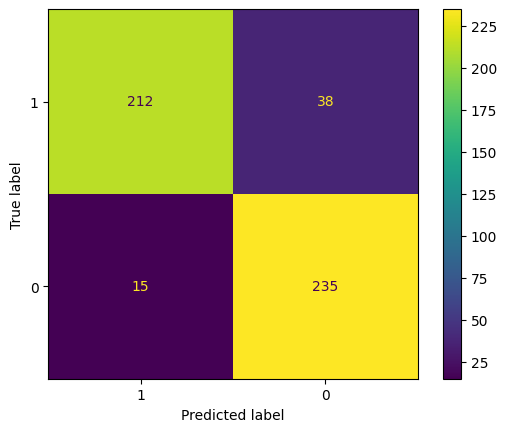

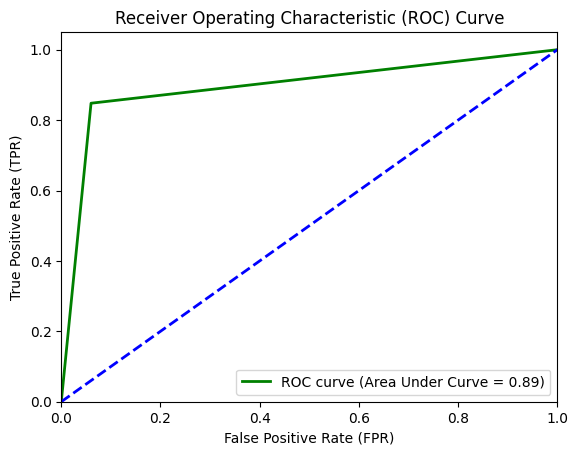

In [48]:
plot_accuracy_curve(model4)
performance(test_df['related_manual'],y_pred4)

In [49]:
siamese_5 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_5.summary()

2023-08-15 14:55:38.672230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:55:38.673514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:55:38.674536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 50)           2345100     ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 subtract_4 (Subtract)          (None, 50)           0           ['sequential_4[0][0]',     

2023-08-15 14:55:39.023116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:55:39.024208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:55:39.025779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
%%time
model5 = siamese_5.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-15 14:55:39.358790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:55:39.359895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:55:39.361119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 140ms/step - loss: 0.5210 - accuracy: 0.7488
Epoch 2/20
154/154 [==============================] - 21s 137ms/step - loss: 0.2130 - accuracy: 0.9500
Epoch 3/20
154/154 [==============================] - 22s 142ms/step - loss: 0.4718 - accuracy: 0.7867
Epoch 4/20
154/154 [==============================] - 21s 139ms/step - loss: 0.2046 - accuracy: 0.9561
Epoch 5/20
154/154 [==============================] - 21s 140ms/step - loss: 0.1204 - accuracy: 0.9880
Epoch 6/20
154/154 [==============================] - 23s 147ms/step - loss: 0.0673 - accuracy: 0.9963
Epoch 7/20
154/154 [==============================] - 22s 140ms/step - loss: 0.0478 - accuracy: 0.9994
Epoch 8/20
154/154 [==============================] - 21s 140ms/step - loss: 0.0483 - accuracy: 0.9976
Epoch 9/20
154/154 [==============================] - 21s 139ms/step - loss: 0.5268 - accuracy: 0.7788
Epoch 10/20
154/154 [==============================] - 21s 139ms/step - loss: 0.3092

In [51]:
%%time
y_pred5 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_5) for tweet in test_df['tweet_preprocessed']]

2023-08-15 15:02:52.392512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:02:52.393428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:02:52.394822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 44ms/step
CPU times: user 1min 36s, sys: 16.8 s, total: 1min 53s
Wall time: 2min 1s


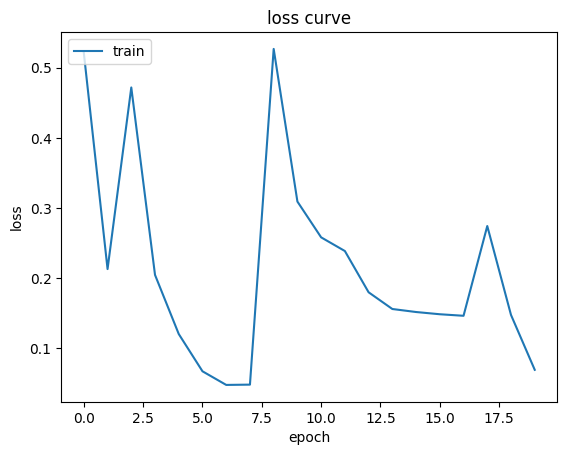

Accuracy: 89.4%
[221  29  24 226]
TP: 221
FP: 24
TN: 226
FN: 29
Sensitivity: 88.4%
Specificity: 90.4%
Precision: 90.204%
Recall: 88.4%
f1: 89.293%


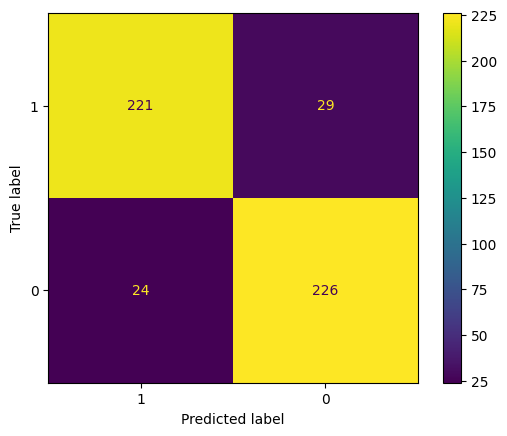

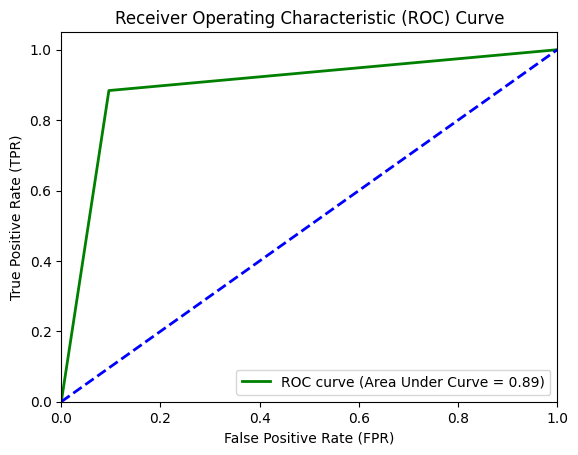

In [52]:
plot_accuracy_curve(model5)
performance(test_df['related_manual'],y_pred5)

In [53]:
siamese_6 = initialise_siamese_network(300,word2vec_embedding_matrix,'sgd',0.01)
siamese_6.summary()

2023-08-15 15:11:20.046757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:11:20.047704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:11:20.049008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 50)           2345100     ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 subtract_5 (Subtract)          (None, 50)           0           ['sequential_5[0][0]',     

2023-08-15 15:11:20.403834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:11:20.404946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:11:20.406082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [54]:
%%time
model6 = siamese_6.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-15 15:11:20.715690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:11:20.716684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:11:20.718165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 24s 137ms/step - loss: 1.1551 - accuracy: 0.5002
Epoch 2/20
154/154 [==============================] - 21s 134ms/step - loss: 0.8783 - accuracy: 0.5024
Epoch 3/20
154/154 [==============================] - 20s 132ms/step - loss: 0.8022 - accuracy: 0.5051
Epoch 4/20
154/154 [==============================] - 21s 136ms/step - loss: 0.7615 - accuracy: 0.5092
Epoch 5/20
154/154 [==============================] - 20s 131ms/step - loss: 0.7361 - accuracy: 0.5145
Epoch 6/20
154/154 [==============================] - 20s 129ms/step - loss: 0.7175 - accuracy: 0.5212
Epoch 7/20
154/154 [==============================] - 21s 134ms/step - loss: 0.7015 - accuracy: 0.5255
Epoch 8/20
154/154 [==============================] - 20s 132ms/step - loss: 0.6863 - accuracy: 0.5333
Epoch 9/20
154/154 [==============================] - 20s 132ms/step - loss: 0.6727 - accuracy: 0.5441
Epoch 10/20
154/154 [==============================] - 20s 130ms/step - loss: 0.6655

In [55]:
%%time
y_pred6 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_6) for tweet in test_df['tweet_preprocessed']]

2023-08-15 15:18:10.441604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:18:10.442514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:18:10.443803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 1s

2023-08-15 15:18:10.754705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 15:18:10.760802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 42ms/step
CPU times: user 1min 34s, sys: 15.5 s, total: 1min 50s
Wall time: 1min 53s


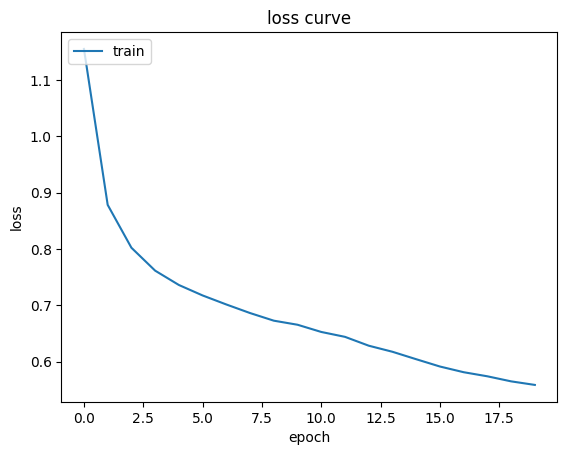

Accuracy: 88.2%
[205  45  14 236]
TP: 205
FP: 14
TN: 236
FN: 45
Sensitivity: 82.0%
Specificity: 94.4%
Precision: 93.607%
Recall: 82.0%
f1: 87.42%


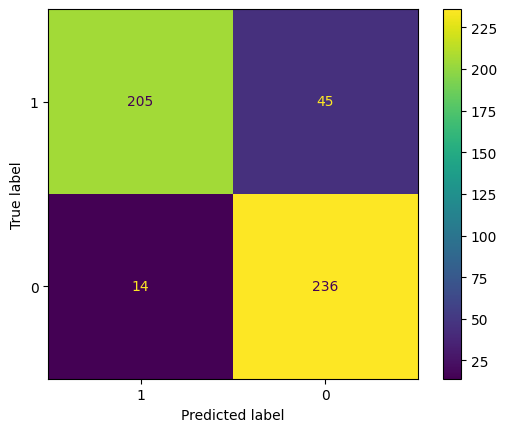

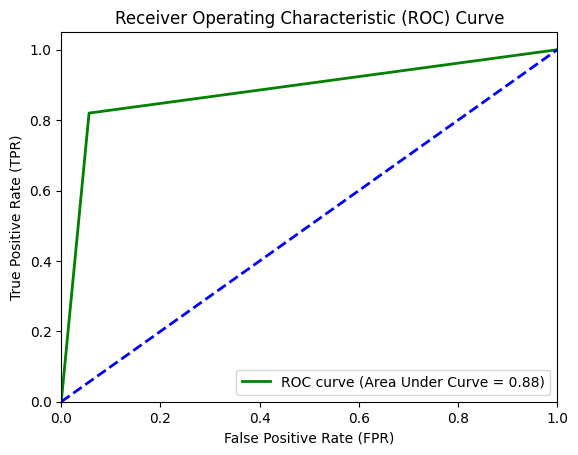

In [56]:
plot_accuracy_curve(model6)
performance(test_df['related_manual'],y_pred6)

In [57]:
siamese_7 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_7.summary()

2023-08-15 15:20:54.550024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:20:54.551136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:20:54.552336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 50)           2345100     ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 subtract_6 (Subtract)          (None, 50)           0           ['sequential_6[0][0]',     

2023-08-15 15:20:54.931468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:20:54.932666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:20:54.933826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [58]:
%%time
model7 = siamese_7.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=30)

Epoch 1/30


2023-08-15 15:20:55.304009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:20:55.305264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:20:55.306479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 142ms/step - loss: 0.4336 - accuracy: 0.8047
Epoch 2/30
154/154 [==============================] - 22s 140ms/step - loss: 0.1671 - accuracy: 0.9631
Epoch 3/30
154/154 [==============================] - 21s 138ms/step - loss: 0.1086 - accuracy: 0.9804
Epoch 4/30
154/154 [==============================] - 21s 134ms/step - loss: 0.0678 - accuracy: 0.9935
Epoch 5/30
154/154 [==============================] - 21s 134ms/step - loss: 0.0549 - accuracy: 0.9986
Epoch 6/30
154/154 [==============================] - 21s 139ms/step - loss: 0.0475 - accuracy: 0.9994
Epoch 7/30
154/154 [==============================] - 20s 133ms/step - loss: 0.5272 - accuracy: 0.8018
Epoch 8/30
154/154 [==============================] - 21s 134ms/step - loss: 0.2276 - accuracy: 0.9420
Epoch 9/30
154/154 [==============================] - 21s 136ms/step - loss: 0.7641 - accuracy: 0.5749
Epoch 10/30
154/154 [==============================] - 21s 134ms/step - loss: 0.5547

In [59]:
%%time
y_pred7 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_7) for tweet in test_df['tweet_preprocessed']]

2023-08-15 15:31:25.347052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:31:25.348133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:31:25.349427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 2s

2023-08-15 15:31:25.654858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 15:31:25.661926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 46ms/step
CPU times: user 1min 33s, sys: 16.2 s, total: 1min 49s
Wall time: 2min 3s


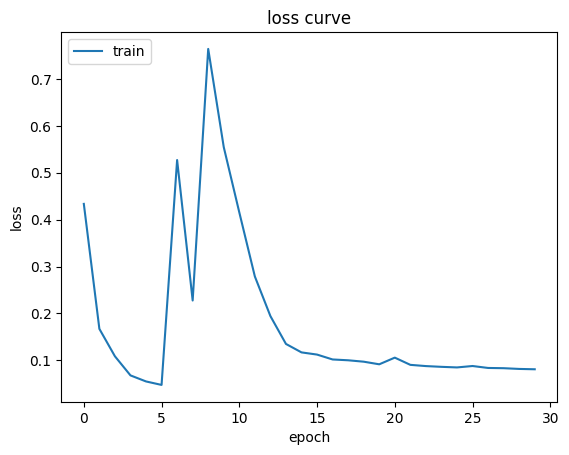

Accuracy: 87.6%
[202  48  14 236]
TP: 202
FP: 14
TN: 236
FN: 48
Sensitivity: 80.8%
Specificity: 94.4%
Precision: 93.519%
Recall: 80.8%
f1: 86.695%


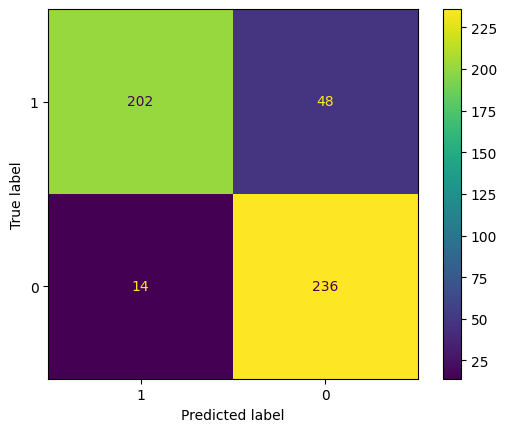

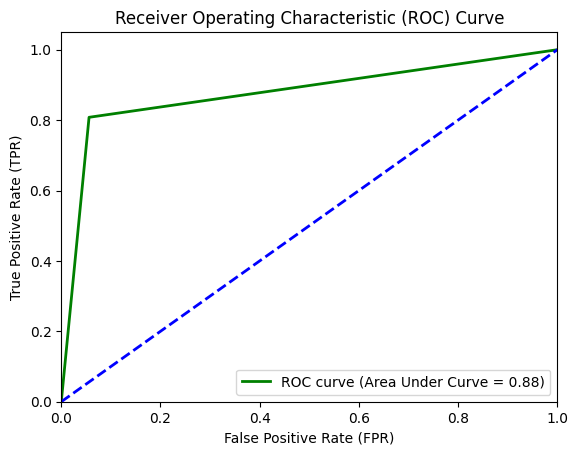

In [60]:
plot_accuracy_curve(model7)
performance(test_df['related_manual'],y_pred7)

<h2>Results<h2>
<h5>The best model is the one with following hyperparamteters
    <ol><li>Epochs - 20</li>
        <li>Learning rate - 0.01</li>
        <li>Optimizer - Adam</li></ol>
    <h5>

| Model              | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|--------------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| Few shot (Siamese) | 89.4%    | 221 | 24 | 226 | 29 | 88.4%       | 90.4%       | 90.204%   | 88.4%  | 89.293%  |